In [1]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/prova_NN

/gdrive/My Drive/prova_NN


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [45]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head(20)

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672
5,7.82592,4.22372,10.11672,1.64906,3.12314,47.010218,3.41862
6,7.52214,4.11250,9.89428,1.58930,3.22440,46.892360,3.24100
7,7.31962,4.00128,9.56062,1.53120,3.12314,45.959439,3.24100
8,7.26982,3.89006,9.56062,1.58930,3.02188,47.126421,3.12314
9,7.26982,4.00128,9.56062,1.70716,2.97208,46.659961,3.24100


In [ ]:
dataset.shape

(68528, 7)

In [6]:
columns = dataset.columns

In [7]:
val_split = 0.1
val_size = dataset.shape[0]//10

In [8]:
window = 200
stride = 10

In [9]:
telescope = 1
target_labels = dataset.columns

In [10]:
temp= dataset
temp['index'] = range(dataset.shape[0])

In [11]:
period = 96
temp['sin'] = np.sin(temp['index'] * (2* np.pi / period))
temp['cos'] = np.cos(temp['index'] * (2 * np.pi / period))
del temp['index']
temp.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root,sin,cos
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434,0.000000,1.000000
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672,0.065403,0.997859
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672,0.130526,0.991445
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672,0.195090,0.980785
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672,0.258819,0.965926


In [13]:
val_split = 0.1
val_size = temp.shape[0]//10

(61676, 9) (6852, 9)


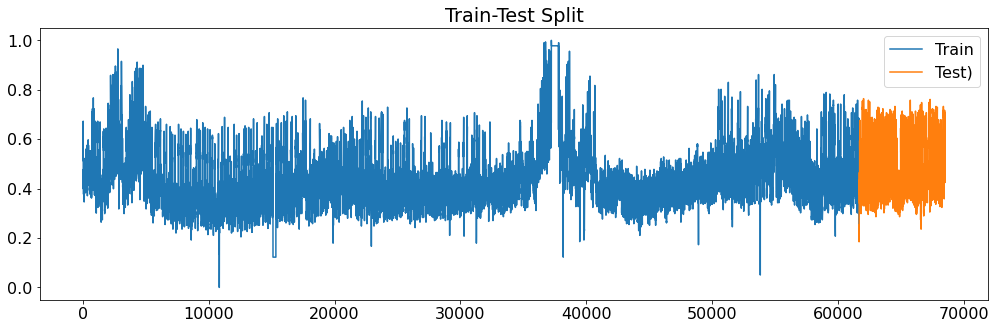

In [12]:
X_train_raw = temp.iloc[:-val_size]

X_val_raw = temp.iloc[-val_size:]

print(X_train_raw.shape, X_val_raw.shape)

# Normalize
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_val_raw = (X_val_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Sponginess'], label='Train')
plt.plot(X_val_raw['Sponginess'], label='Test)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [14]:
def build_sequences2(df, target_labels=['Sponginess'], window=200, stride=20, telescope=1,col = dataset.columns):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[col].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [15]:
telescope = 1
target_labels = temp.columns

In [46]:
col = dataset.columns

In [47]:
X_train, y_train = build_sequences2(X_train_raw, target_labels, window, stride, telescope,col)
X_val, y_val = build_sequences2(X_val_raw, target_labels, window, stride, telescope, col)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6160, 200, 9), (6160, 1, 7), (680, 200, 9), (680, 1, 7))

In [18]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[2]
batch_size = 32
epochs = 50

In [ ]:
def build_1DCNN(input_shape,output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(64,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    dense = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(output_shape, activation='linear')(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
    
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 9)]          0         
                                                                 
 conv1d_20 (Conv1D)          (None, 200, 64)           1792      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 100, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 100, 128)          24704     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 50, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 50, 128)           49280 

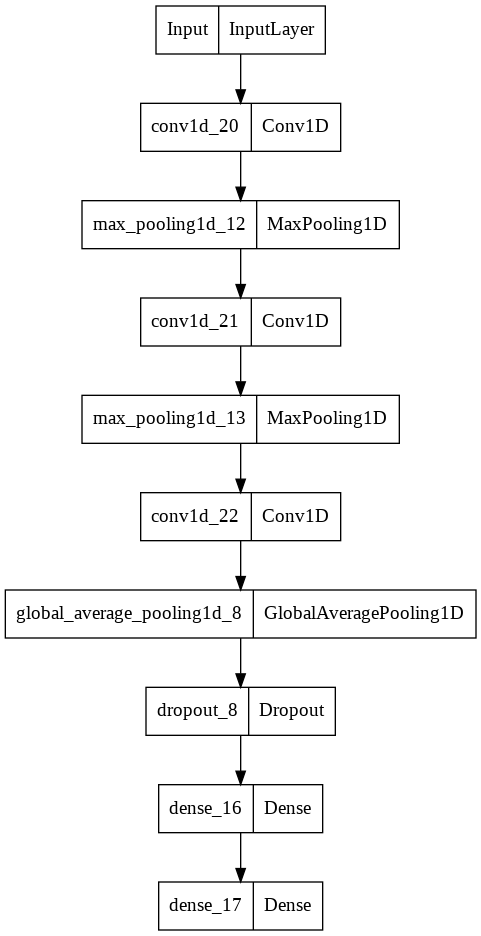

In [ ]:
model = build_1DCNN(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/50
174/174 [==============================] - 8s 42ms/step - loss: 0.0304 - mae: 0.1317 - val_loss: 0.0205 - val_mae: 0.1097 - lr: 0.0010
Epoch 2/50
174/174 [==============================] - 7s 41ms/step - loss: 0.0225 - mae: 0.1138 - val_loss: 0.0219 - val_mae: 0.1126 - lr: 0.0010
Epoch 3/50
174/174 [==============================] - 7s 41ms/step - loss: 0.0212 - mae: 0.1093 - val_loss: 0.0233 - val_mae: 0.1140 - lr: 0.0010
Epoch 4/50
174/174 [==============================] - 7s 41ms/step - loss: 0.0208 - mae: 0.1078 - val_loss: 0.0225 - val_mae: 0.1127 - lr: 0.0010
Epoch 5/50
174/174 [==============================] - 7s 41ms/step - loss: 0.0207 - mae: 0.1074 - val_loss: 0.0226 - val_mae: 0.1100 - lr: 0.0010
Epoch 6/50
174/174 [==============================] - 7s 41ms/step - loss: 0.0206 - mae: 0.1069 - val_loss: 0.0219 - val_mae: 0.1108 - lr: 0.0010
Epoch 7/50
174/174 [==============================] - 7s 41ms/step - loss: 0.0206 - mae: 0.1069 - val_loss: 0.0221 - val_mae

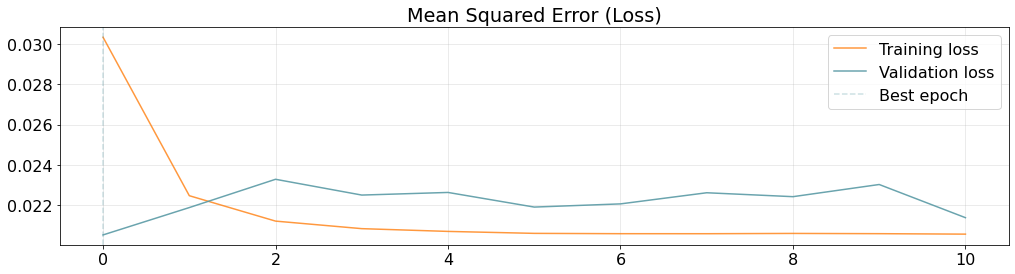

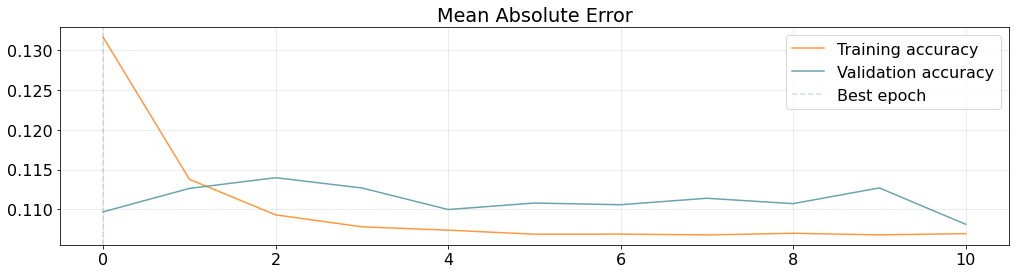

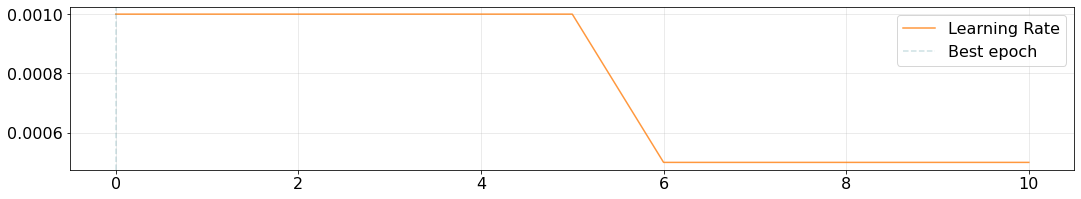

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set 
predictions = model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(680, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.022718677>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11717873>)

In [69]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
X_val.shape 
y_val.shape 
predictions.shape 
np.reshape(predictions,(680,1,7))

array([[[0.28351587, 0.31770703, 0.39874062, ..., 0.3183014 ,
         0.23365632, 0.4332295 ]],

       [[0.29268685, 0.33027226, 0.41424462, ..., 0.33127445,
         0.24123883, 0.4484148 ]],

       [[0.3023189 , 0.34363502, 0.42997053, ..., 0.34494418,
         0.24905995, 0.46438402]],

       ...,

       [[0.4011995 , 0.48799923, 0.59895986, ..., 0.47122133,
         0.33478308, 0.6335528 ]],

       [[0.39961842, 0.4863313 , 0.5971406 , ..., 0.46936527,
         0.33356106, 0.63137233]],

       [[0.39890033, 0.48552692, 0.5959756 , ..., 0.46828294,
         0.3326671 , 0.6299398 ]]], dtype=float32)

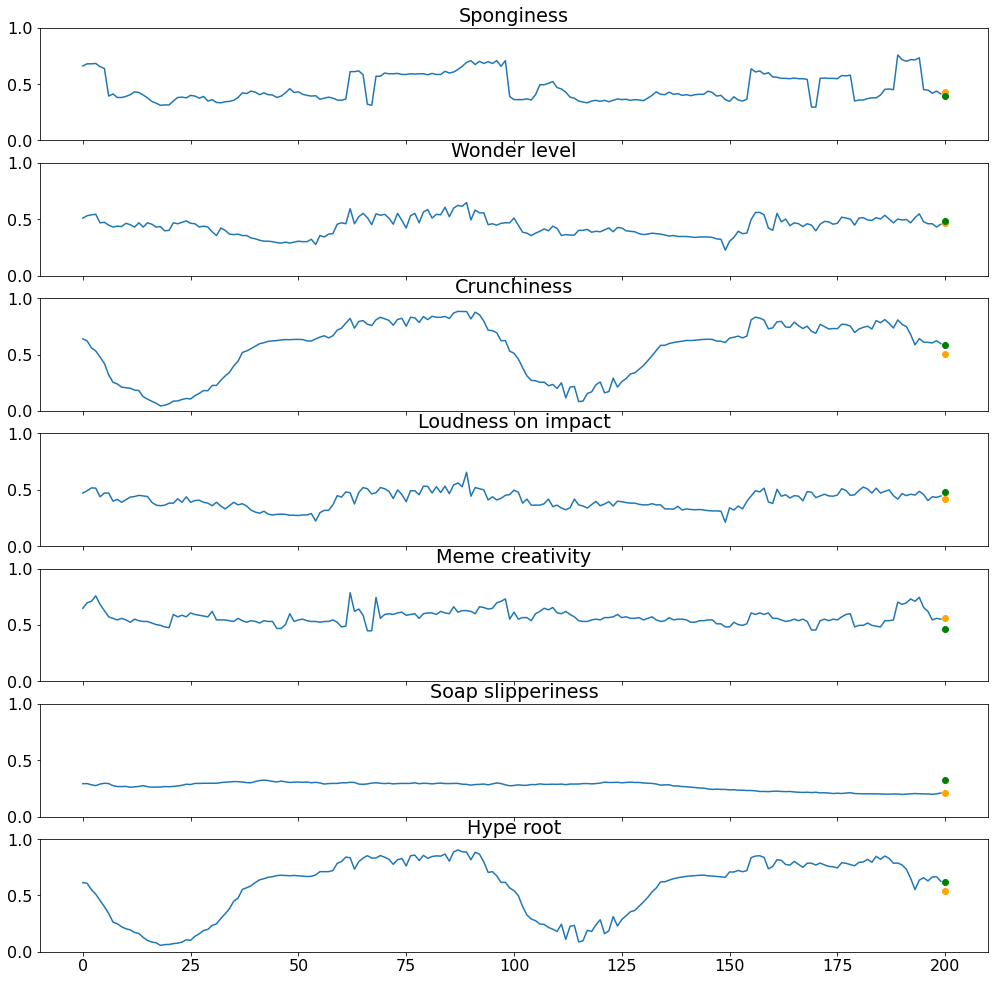

In [ ]:
inspect_multivariate_prediction(X_val, y_val, np.reshape(predictions,(680,1,7)), col, telescope)

In [ ]:
reg_telescope = 864
X_val_reg, y_val_reg = build_sequences2(X_val_raw, target_labels, window, stride, reg_telescope, col)
X_val_reg.shape 
y_val_reg.shape

(594, 864, 7)

In [ ]:
X_val_reg.shape 

(594, 200, 9)

In [ ]:
reg_predictions = np.array([])
X_temp = X_val_reg
new_shape = (X_val_reg.shape[0],1,1)
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    next_x = np.reshape(pred_temp,(X_val_reg.shape[0],1,7))
    next_sin = np.sin(np.arcsin(X_temp[:,-1,7]) + np.sin(2*np.pi/period))
    next_cos = np.cos(np.arccos(X_temp[:,-1,8]) + np.cos(2*np.pi/period))
    next_x = np.concatenate((next_x,np.reshape(next_sin,new_shape)), axis=-1)
    next_x = np.concatenate((next_x,np.reshape(next_cos,new_shape)), axis=-1)
    if(len(reg_predictions)==0):
        reg_predictions = np.reshape(pred_temp,(X_val_reg.shape[0],1,7))
    else:
        reg_predictions = np.concatenate((reg_predictions,np.reshape(pred_temp,(X_val_reg.shape[0],1,7))),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],next_x), axis=1)

In [ ]:
reg_predictions.shape

(594, 864, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_val_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.041835602>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1563127>)

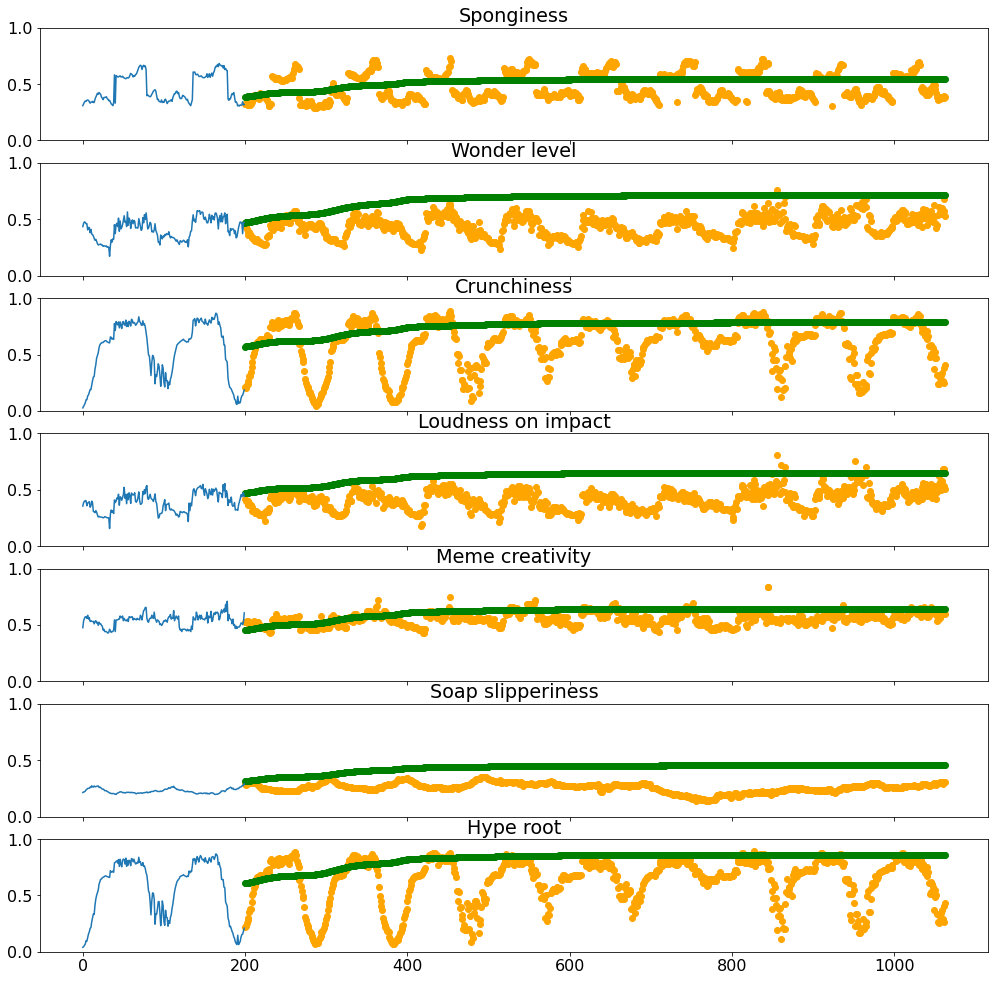

In [ ]:
inspect_multivariate_prediction(X_val_reg, y_val_reg, reg_predictions, col, reg_telescope)

In [ ]:
def build_1DCNN_2(input_shape,output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(64,96,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    dense = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(output_shape, activation='linear')(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
    
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 9)]          0         
                                                                 
 conv1d_23 (Conv1D)          (None, 200, 64)           55360     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 100, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 100, 128)          41088     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 50, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 50, 128)           49280 

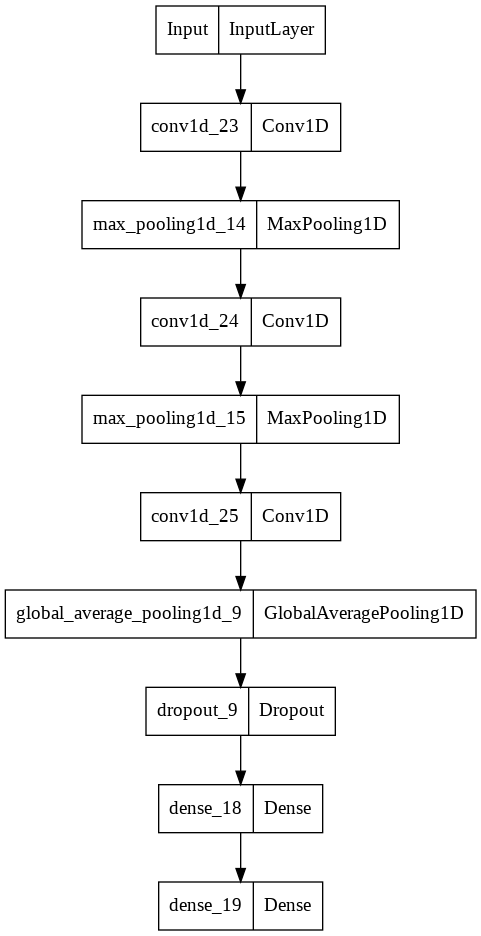

In [ ]:
model = build_1DCNN_2(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/20
174/174 [==============================] - 18s 97ms/step - loss: 0.0306 - mae: 0.1317 - val_loss: 0.0250 - val_mae: 0.1256 - lr: 0.0010
Epoch 2/20
174/174 [==============================] - 16s 92ms/step - loss: 0.0226 - mae: 0.1142 - val_loss: 0.0225 - val_mae: 0.1132 - lr: 0.0010
Epoch 3/20
174/174 [==============================] - 17s 96ms/step - loss: 0.0216 - mae: 0.1107 - val_loss: 0.0241 - val_mae: 0.1134 - lr: 0.0010
Epoch 4/20
174/174 [==============================] - 16s 95ms/step - loss: 0.0210 - mae: 0.1084 - val_loss: 0.0226 - val_mae: 0.1126 - lr: 0.0010
Epoch 5/20
174/174 [==============================] - 17s 99ms/step - loss: 0.0208 - mae: 0.1077 - val_loss: 0.0227 - val_mae: 0.1101 - lr: 0.0010
Epoch 6/20
174/174 [==============================] - 17s 98ms/step - loss: 0.0206 - mae: 0.1070 - val_loss: 0.0220 - val_mae: 0.1112 - lr: 0.0010
Epoch 7/20
174/174 [==============================] - 16s 92ms/step - loss: 0.0207 - mae: 0.1073 - val_loss: 0.0218 - 

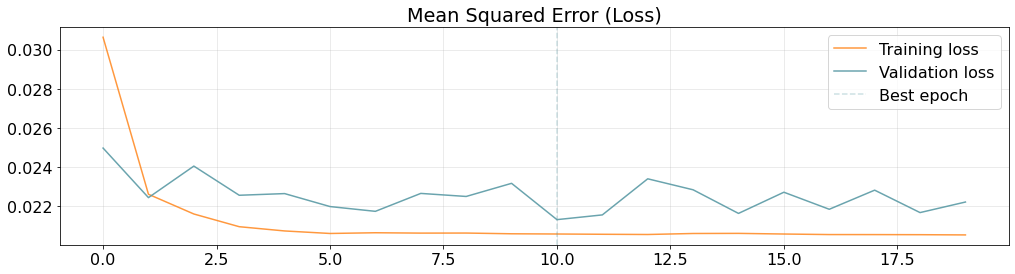

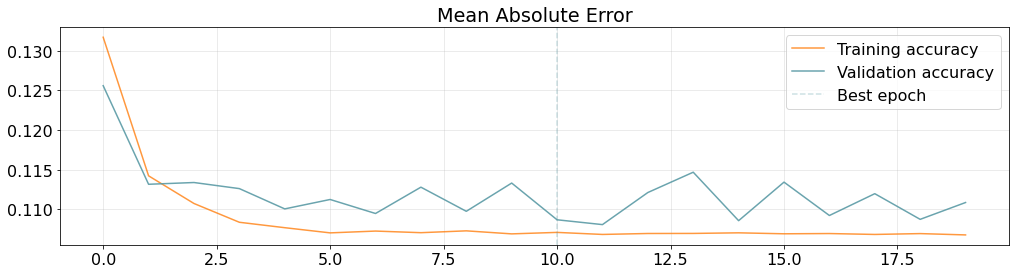

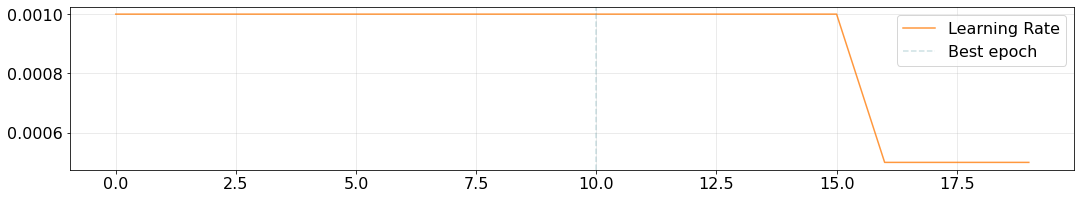

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set 
predictions = model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(680, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.023014111>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11546838>)

In [ ]:
reg_telescope = 200
X_val_reg, y_val_reg = build_sequences2(X_val_raw, target_labels, window, stride, reg_telescope, col)
X_val_reg.shape 
y_val_reg.shape

(660, 200, 7)

In [ ]:
reg_predictions = np.array([])
X_temp = X_val_reg
new_shape = (X_val_reg.shape[0],1,1)
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    next_x = np.reshape(pred_temp,(X_val_reg.shape[0],1,7))
    next_sin = np.sin(np.arcsin(X_temp[:,-1,7]) + np.sin(2*np.pi/period))
    next_cos = np.cos(np.arccos(X_temp[:,-1,8]) + np.cos(2*np.pi/period))
    next_x = np.concatenate((next_x,np.reshape(next_sin,new_shape)), axis=-1)
    next_x = np.concatenate((next_x,np.reshape(next_cos,new_shape)), axis=-1)
    if(len(reg_predictions)==0):
        reg_predictions = np.reshape(pred_temp,(X_val_reg.shape[0],1,7))
    else:
        reg_predictions = np.concatenate((reg_predictions,np.reshape(pred_temp,(X_val_reg.shape[0],1,7))),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],next_x), axis=1)

In [ ]:
reg_predictions.shape

(660, 200, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_val_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.023144636>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11578913>)

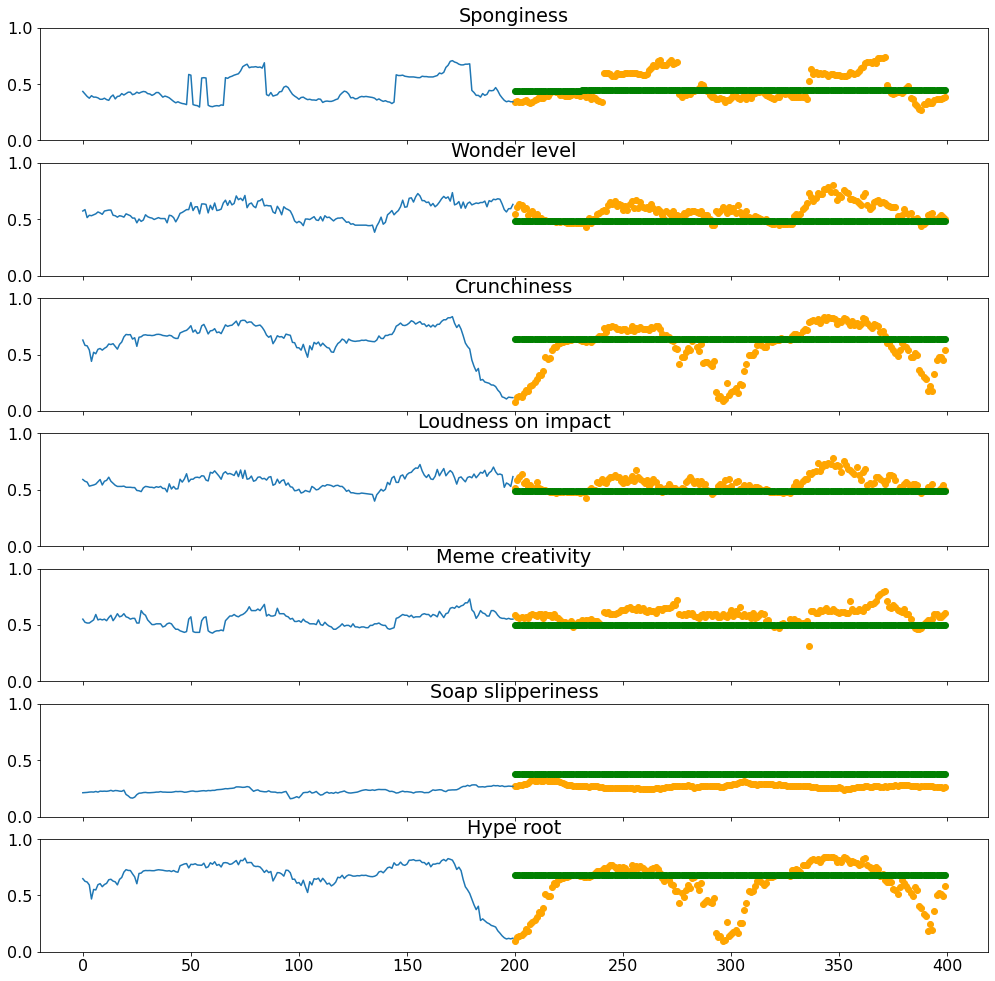

In [ ]:
inspect_multivariate_prediction(X_val_reg, y_val_reg, reg_predictions, col, reg_telescope)

it is just learning the average value

i will try with LSTM

In [ ]:
def build_BiLSTM(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer) #tfkl.Bidirectional for each type of architecture
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.2, seed=seed)(bilstm)

    # Classifier
    dense = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(output_shape, activation='linear')(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 9)]          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 200, 256)         141312    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 200, 256)         394240    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                             

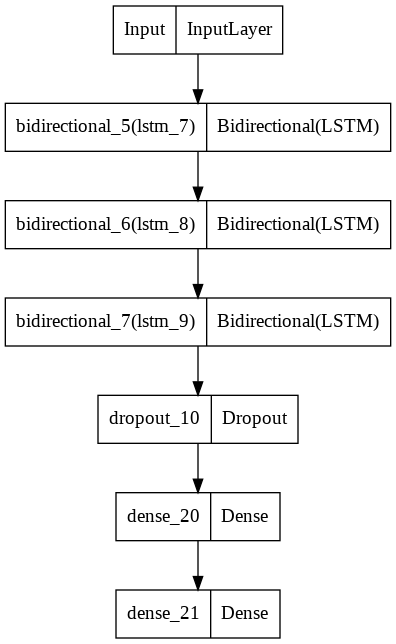

In [ ]:
model = build_BiLSTM(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/20
174/174 [==============================] - 390s 2s/step - loss: 0.0260 - mae: 0.1204 - val_loss: 0.0215 - val_mae: 0.1134 - lr: 0.0010
Epoch 2/20
174/174 [==============================] - 344s 2s/step - loss: 0.0220 - mae: 0.1121 - val_loss: 0.0223 - val_mae: 0.1107 - lr: 0.0010
Epoch 3/20
174/174 [==============================] - 341s 2s/step - loss: 0.0216 - mae: 0.1104 - val_loss: 0.0247 - val_mae: 0.1143 - lr: 0.0010
Epoch 4/20
174/174 [==============================] - 341s 2s/step - loss: 0.0215 - mae: 0.1100 - val_loss: 0.0219 - val_mae: 0.1109 - lr: 0.0010
Epoch 5/20
174/174 [==============================] - 338s 2s/step - loss: 0.0212 - mae: 0.1093 - val_loss: 0.0226 - val_mae: 0.1107 - lr: 0.0010
Epoch 6/20
174/174 [==============================] - 341s 2s/step - loss: 0.0210 - mae: 0.1085 - val_loss: 0.0214 - val_mae: 0.1114 - lr: 0.0010
Epoch 7/20
174/174 [==============================] - 340s 2s/step - loss: 0.0213 - mae: 0.1095 - val_loss: 0.0223 - val_mae

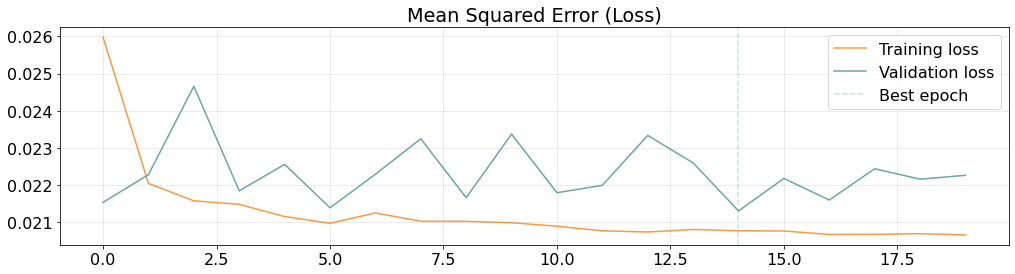

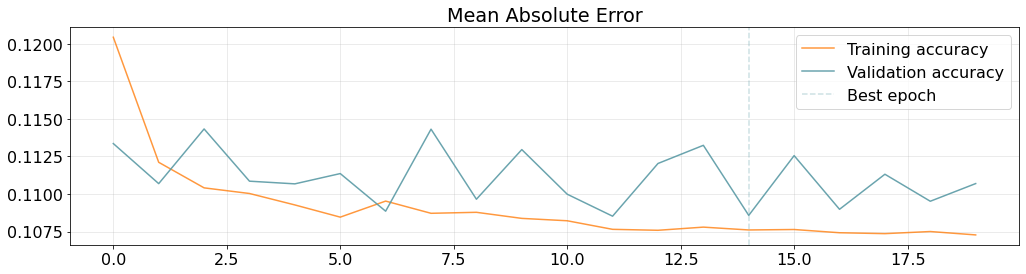

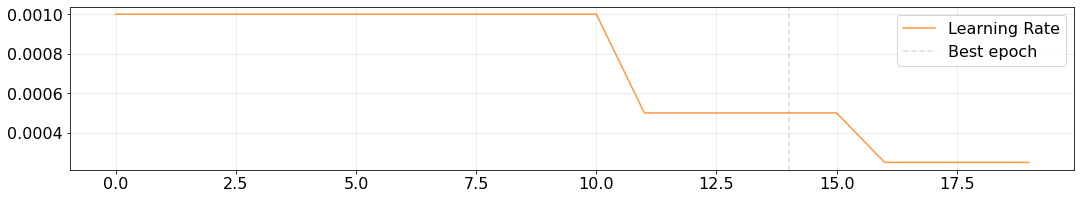

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set 
predictions = model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(680, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.022384025>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11357518>)

In [ ]:
reg_telescope = 864
X_val_reg, y_val_reg = build_sequences2(X_val_raw, target_labels, window, stride, reg_telescope, col)
X_val_reg.shape 
y_val_reg.shape

(594, 864, 7)

In [ ]:
reg_predictions = np.array([])
X_temp = X_val_reg
new_shape = (X_val_reg.shape[0],1,1)
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    next_x = np.reshape(pred_temp,(X_val_reg.shape[0],1,7))
    next_sin = np.sin(np.arcsin(X_temp[:,-1,7]) + np.sin(2*np.pi/period))
    next_cos = np.cos(np.arccos(X_temp[:,-1,8]) + np.cos(2*np.pi/period))
    next_x = np.concatenate((next_x,np.reshape(next_sin,new_shape)), axis=-1)
    next_x = np.concatenate((next_x,np.reshape(next_cos,new_shape)), axis=-1)
    if(len(reg_predictions)==0):
        reg_predictions = np.reshape(pred_temp,(X_val_reg.shape[0],1,7))
    else:
        reg_predictions = np.concatenate((reg_predictions,np.reshape(pred_temp,(X_val_reg.shape[0],1,7))),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],next_x), axis=1)

In [ ]:
reg_predictions.shape

(594, 582, 7)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_val_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
inspect_multivariate_prediction(X_val_reg[:100], y_val_reg[:100], reg_predictions[:100], col, 582)

In [ ]:
plt.plot(predictions[:,2])

still not working 

i want to add multiple different sizes of convolutions and add them to extract patterns at different scales

In [27]:
def build_1DCNN2(input_shape,output_shape):
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor

    c1 = tfkl.Conv1D(64,3,padding='same',activation='relu')(input_layer)
    c1 = tfkl.MaxPooling1D()(c1)
    c1 = tfkl.Conv1D(128,3,padding='same',activation='relu')(c1)
    gap1 = tfkl.GlobalAveragePooling1D()(c1)

    c2 = tfkl.Conv1D(64,6,padding='same',activation='relu')(input_layer)
    c2 = tfkl.MaxPooling1D()(c2)
    c2 = tfkl.Conv1D(128,6,padding='same',activation='relu')(c2)
    gap2 = tfkl.GlobalAveragePooling1D()(c2)

    c3 = tfkl.Conv1D(64,12,padding='same',activation='relu')(input_layer)
    c3 = tfkl.MaxPooling1D()(c3)
    c3 = tfkl.Conv1D(128,12,padding='same',activation='relu')(c3)
    gap3 = tfkl.GlobalAveragePooling1D()(c3)

    c4 = tfkl.Conv1D(64,24,padding='same',activation='relu')(input_layer)
    c4 = tfkl.MaxPooling1D()(c4)
    c4 = tfkl.Conv1D(128,24,padding='same',activation='relu')(c4)
    gap4 = tfkl.GlobalAveragePooling1D()(c4)

    c5 = tfkl.Conv1D(64,48,padding='same',activation='relu')(input_layer)
    c5 = tfkl.MaxPooling1D()(c5)
    c5 = tfkl.Conv1D(128,48,padding='same',activation='relu')(c5)
    gap5 = tfkl.GlobalAveragePooling1D()(c5)

    c6 = tfkl.Conv1D(64,96,padding='same',activation='relu')(input_layer)
    c6 = tfkl.MaxPooling1D()(c6)
    c6 = tfkl.Conv1D(128,96,padding='same',activation='relu')(c6)
    gap6 = tfkl.GlobalAveragePooling1D()(c6)
    
    block_1_output = tfkl.add([c1,c2])
    block_2_output = tfkl.add([c3,c4])
    block_3_output = tfkl.add([c5,c6])

    c12 = tfkl.Conv1D(32,3,padding='same',activation='relu')(block_1_output)
    c34 = tfkl.Conv1D(32,3,padding='same',activation='relu')(block_2_output)
    c56 = tfkl.Conv1D(32,3,padding='same',activation='relu')(block_3_output)

    final = tfkl.add([c12,c34,c56])

    gap = tfkl.GlobalAveragePooling1D()(final)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)
    dense = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(output_shape, activation='linear')(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
    
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 200, 9)]     0           []                               
                                                                                                  
 conv1d_79 (Conv1D)             (None, 200, 64)      1792        ['Input[0][0]']                  
                                                                                                  
 conv1d_81 (Conv1D)             (None, 200, 64)      3520        ['Input[0][0]']                  
                                                                                                  
 conv1d_83 (Conv1D)             (None, 200, 64)      6976        ['Input[0][0]']                  
                                                                                              

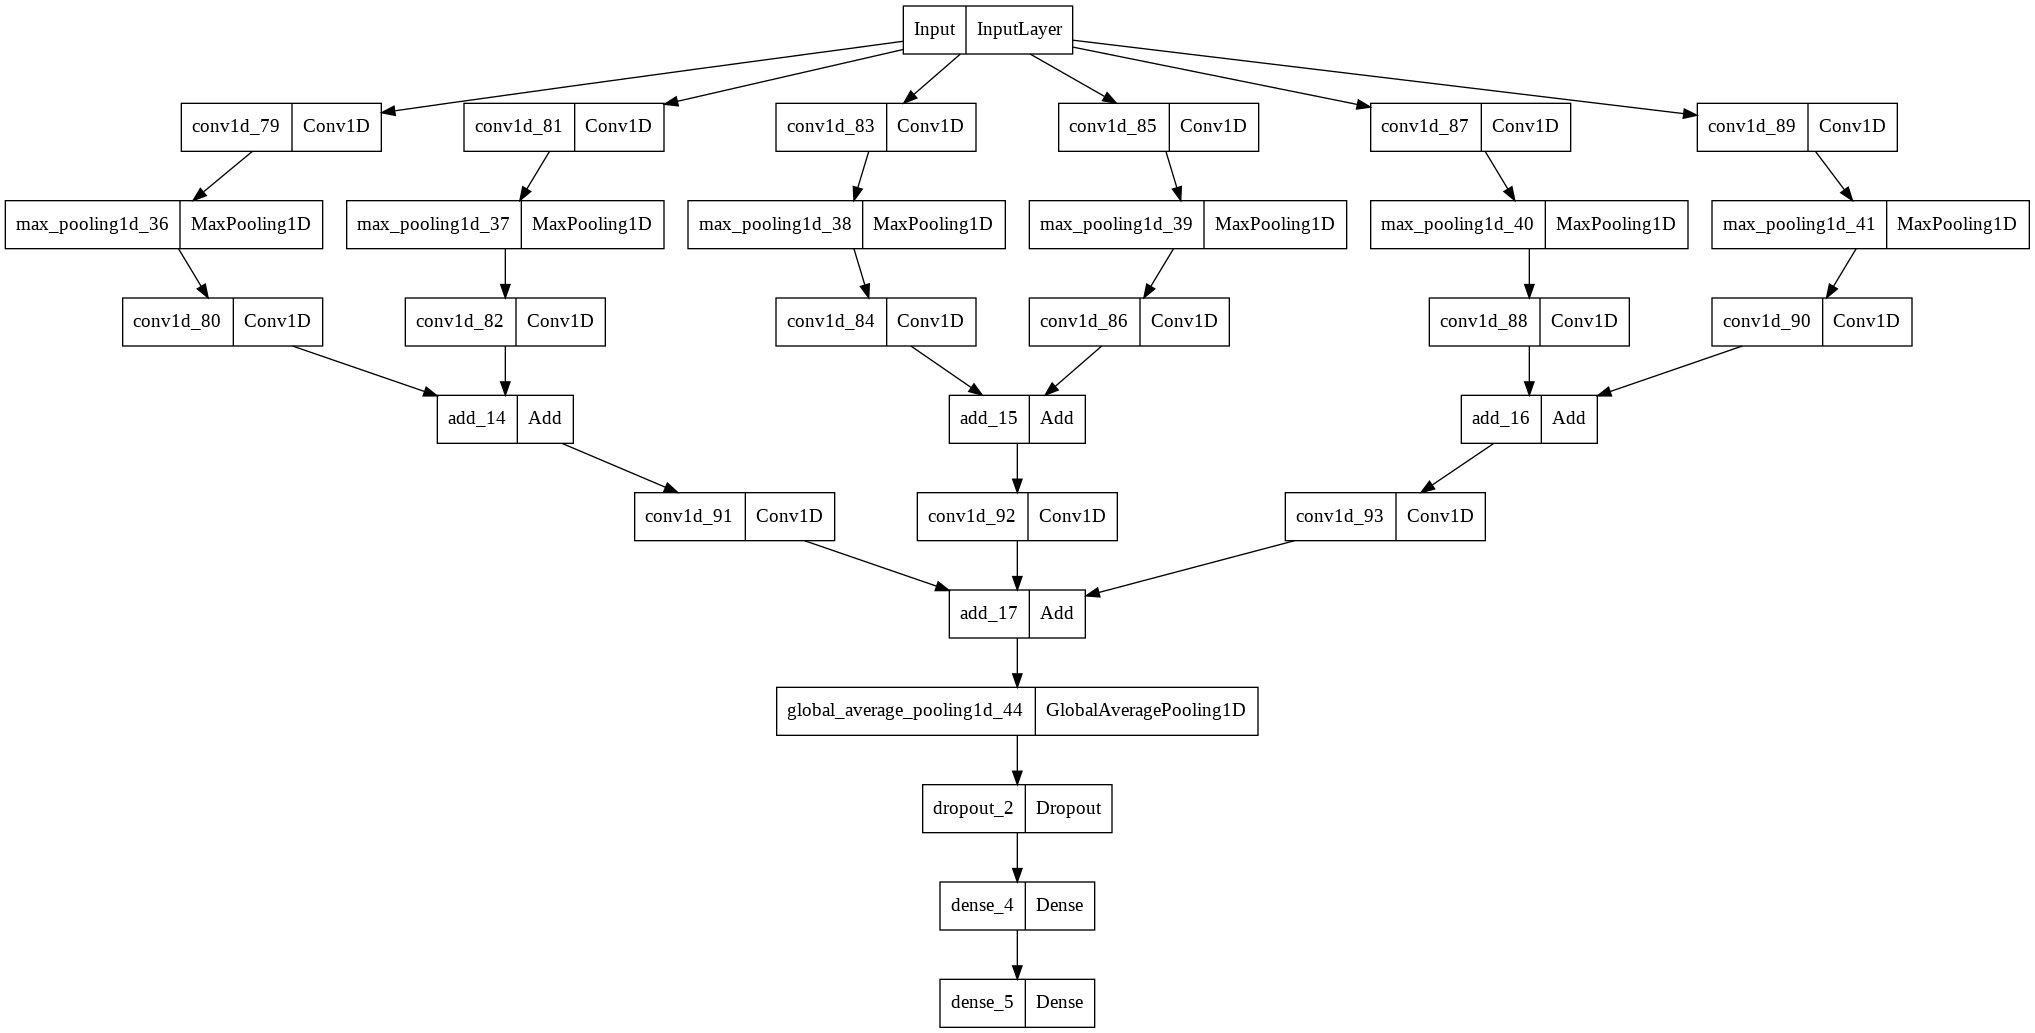

In [49]:
model = build_1DCNN2(input_shape, 7)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [50]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 50,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/50
174/174 [==============================] - 8s 37ms/step - loss: 0.0383 - mae: 0.1441 - val_loss: 0.0257 - val_mae: 0.1285 - lr: 0.0010
Epoch 2/50
174/174 [==============================] - 5s 31ms/step - loss: 0.0223 - mae: 0.1130 - val_loss: 0.0243 - val_mae: 0.1233 - lr: 0.0010
Epoch 3/50
174/174 [==============================] - 6s 32ms/step - loss: 0.0212 - mae: 0.1091 - val_loss: 0.0238 - val_mae: 0.1177 - lr: 0.0010
Epoch 4/50
174/174 [==============================] - 6s 33ms/step - loss: 0.0208 - mae: 0.1078 - val_loss: 0.0227 - val_mae: 0.1145 - lr: 0.0010
Epoch 5/50
174/174 [==============================] - 6s 33ms/step - loss: 0.0207 - mae: 0.1073 - val_loss: 0.0225 - val_mae: 0.1102 - lr: 0.0010
Epoch 6/50
174/174 [==============================] - 5s 31ms/step - loss: 0.0206 - mae: 0.1069 - val_loss: 0.0217 - val_mae: 0.1110 - lr: 0.0010
Epoch 7/50
174/174 [==============================] - 5s 31ms/step - loss: 0.0206 - mae: 0.1071 - val_loss: 0.0214 - val_mae

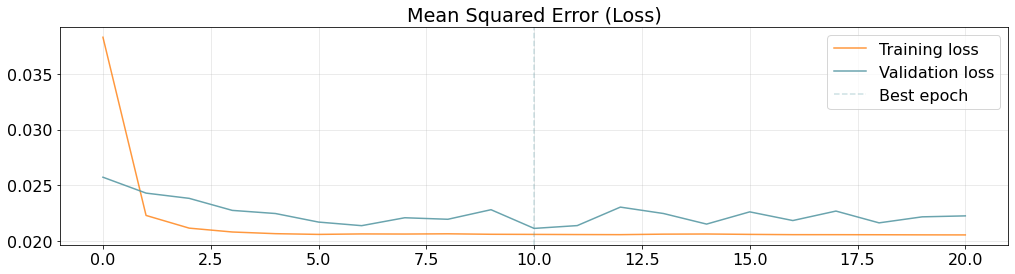

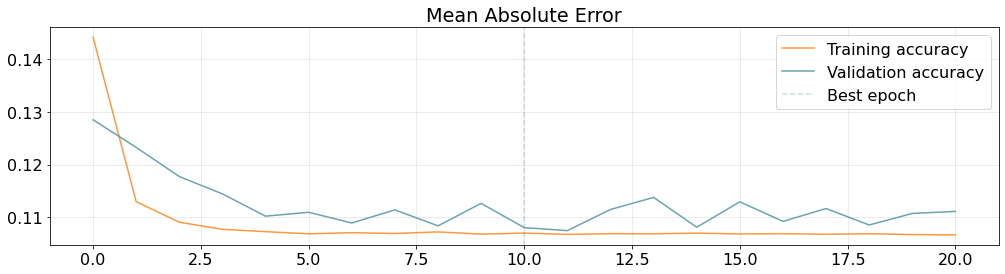

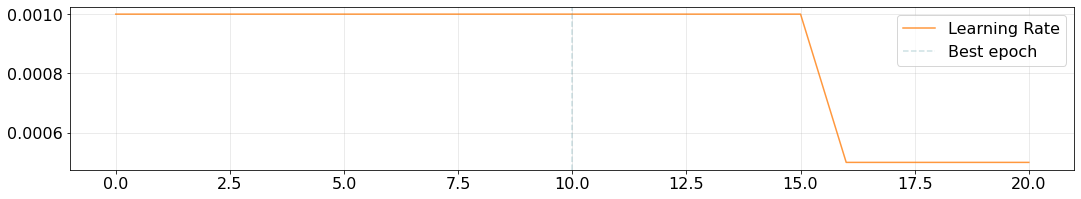

In [55]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [56]:
# Predict the test set 
predictions = model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(680, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.022466468>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11225045>)

In [57]:
reg_telescope = 864
X_val_reg, y_val_reg = build_sequences2(X_val_raw, target_labels, window, stride, reg_telescope, col)
X_val_reg.shape 
y_val_reg.shape

(594, 864, 7)

In [58]:
def find_theta(X_temp):
  prev_sin = X_temp[:,-1,7]
  prev_cos = X_temp[:,-1,8]
  thetas = np.arcsin(prev_sin)
  thetac = np.arccos(prev_cos)
  theta = thetas
  for i in range(len(theta)):
    if(prev_sin[i] >= 0 and prev_cos[i] < 0):
      theta[i] = thetac[i]
    if(prev_sin[i] < 0 and prev_cos[i] < 0):
      theta[i] = -1*thetac[i]
  return theta


In [61]:
next_x.shape

(594, 9)

In [62]:
pred_temp.shape

(594, 7)

In [63]:
X_temp.shape

(594, 200, 9)

In [64]:
next_sin.shape

(594,)

In [80]:
reg_predictions = np.array([])
X_temp = X_val_reg
new_shape = (X_val_reg.shape[0],1,1)
new_shape2 = (X_val_reg.shape[0],1,7)
new_shape3 = (X_val_reg.shape[0],1,8)
theta = find_theta(X_val_reg)
curr_theta = theta
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    next_x = pred_temp
    curr_theta = curr_theta + 2*np.pi/period
    next_sin = np.sin(curr_theta)
    next_cos = np.cos(curr_theta)
    next_x = np.concatenate((np.reshape(next_x,new_shape2),np.reshape(next_sin,new_shape)), axis=-1)
    next_x = np.concatenate((np.reshape(next_x,new_shape3),np.reshape(next_cos,new_shape)), axis=-1)
    if(len(reg_predictions)==0):
        reg_predictions = np.reshape(pred_temp,new_shape2)
    else:
        reg_predictions = np.concatenate((reg_predictions,np.reshape(pred_temp,new_shape2)),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],next_x), axis=1)

In [79]:
pred_temp.shape

(594, 7)

In [81]:
reg_predictions.shape

(594, 864, 7)

In [82]:
mean_squared_error = tfk.metrics.mse(y_val_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.021740656>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11007032>)

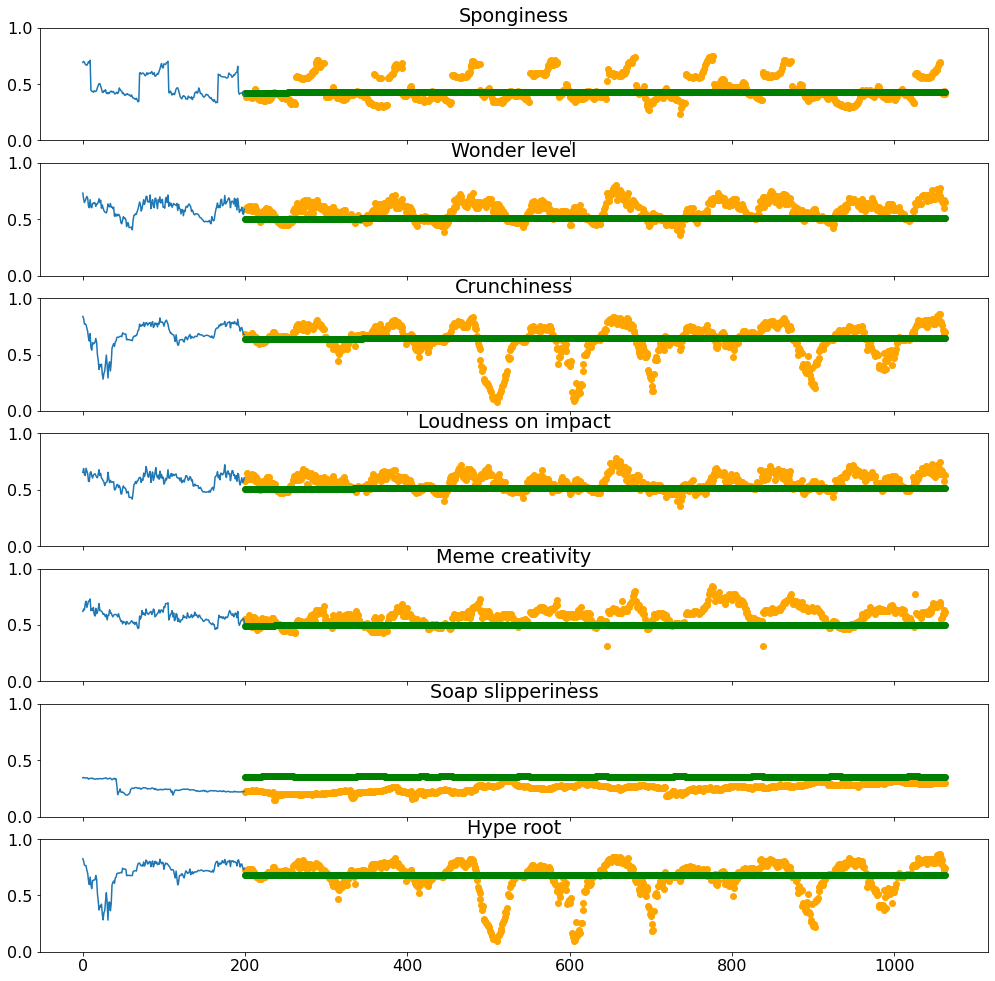

In [83]:
inspect_multivariate_prediction(X_val_reg, y_val_reg, reg_predictions, col, reg_telescope)  